In [ ]:
#IMPORTS

In [2]:
import logging
import os

logging.getLogger("numexpr").setLevel(logging.ERROR)

from bravado.client import SwaggerClient
from IPython.display import display, Markdown

import nglview as nv

import opencadd 

from pathlib import Path
import requests

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import biotite.sequence.align as align

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
from rdkit.Chem import (
    ChemicalFeatures,
    rdDistGeom,
    Draw,
    rdMolTransforms,
    AllChem,
)
import collections
from collections import Counter

from Bio.PDB import PDBParser, PDBIO, Select
from pathlib import Path
import time
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import nglview as nv
import openbabel
import numpy as np
from matplotlib import colors
from plip.structure.preparation import PDBComplex
from plip.exchange.report import BindingSiteReport

from opencadd.structure.core import Structure


In [3]:
#DATA EXTRACTION USING KLIFS PDB API

In [4]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [5]:
KLIFS_API_DEFINITIONS = "https://klifs.net/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={"validate_responses": False})

In [6]:
kinase_groups = KLIFS_CLIENT.Information.get_kinase_groups().response().result
display(Markdown("All kinase groups are returned as a list of strings:"))
print(kinase_groups)

All kinase groups are returned as a list of strings:

['AGC', 'CAMK', 'CK1', 'CMGC', 'Other', 'STE', 'TK', 'TKL']


In [7]:
species = "Human"
kinase_group = "AGC"

In [8]:
kinases = (
    KLIFS_CLIENT.Information.get_kinase_names(kinase_group=kinase_group, species=species)
    .response()
    .result
)
display(
    Markdown(
        f"Kinases in the human group {kinase_group} as a list of objects "
        f"that contain kinase-specific information:"
    )
)

Kinases in the human group AGC as a list of objects that contain kinase-specific information:

In [9]:
kinase_klifs_id = []
x=0
for kinase in kinases:
    kinase_klifs_id.append(kinase.kinase_ID)
    # display(Markdown(f"Kinase KLIFS ID for {kinase.name}: {kinase_klifs_id[x]}"))
    x=x+1
len(kinase_klifs_id)

64

In [10]:
def get_structures(x):
    structures = (
        KLIFS_CLIENT.Structures.get_structures_list(kinase_ID=[x]).response().result)
    # If structures do not contain ligands, the ligand field is set to 0
    # structure = next(structure for structure in structures if structure.ligand != 0)
    return structures

In [11]:
structures=[]
for x in kinase_klifs_id :
    try:
        structures.append(get_structures(x))  
    except:
        pass

In [ ]:
#SCREENING STRUCTURES FOR QUALITY 

In [12]:
structure_master=[]
valid_ids=[]

for structure in structures :
    for x in structure :
        if x.ligand != 0 and x.DFG == 'in' and x.resolution <= 3 and x.quality_score >= 6:
            structure_master.append(x)
            valid_ids.append(x.structure_ID)
len(structure_master)      

441

In [369]:
pdb_block=KLIFS_CLIENT.Structures.get_structure_get_pdb_complex(structure_ID=structure_master[0].structure_ID).response().result

In [ ]:
#PLIP INTERACTION EXTRACTION

In [372]:
#storing pdb_block temporarily as pdb_file for passing to load_pdb
def store_pdb_block_as_file(pdb_block, file_path):
    with open(file_path, 'w') as pdb_file:
        pdb_file.write(pdb_block)
file_path = 'temp.pdb'
store_pdb_block_as_file(pdb_block, file_path)

In [ ]:
protlig= PDBComplex()
protlig.load_pdb(file_path)
protlig.ligands

In [50]:
for ligand in protlig.ligands:
    protlig.characterize_complex(ligand)

In [56]:
protlig.interaction_sets.items()

dict_items([('SEP:B:676', <plip.structure.preparation.PLInteraction object at 0x7fe9fe1b8fa0>), ('SEP:B:695', <plip.structure.preparation.PLInteraction object at 0x7fe9fe08dfa0>), ('Q3L:B:801', <plip.structure.preparation.PLInteraction object at 0x7fe9fe040f40>)])

In [59]:
def retrieve_plip_interactions(pdb_file):
    """
    Retrieves the interactions from PLIP.

    Parameters
    ----------
    pdb_file :
        The PDB file of the complex.

    Returns
    -------
    dict :
        A dictionary of the binding sites and the interactions.
    """
    protlig = PDBComplex()
    protlig.load_pdb(pdb_file)  # load the pdb file
    for ligand in protlig.ligands:
        protlig.characterize_complex(ligand)  # find ligands and analyze interactions
    sites = {}
    # loop over binding sites
    for key, site in sorted(protlig.interaction_sets.items()):
        binding_site = BindingSiteReport(site)  # collect data about interactions
        # tuples of *_features and *_info will be converted to pandas DataFrame
        keys = (
            "hydrophobic",
            "hbond",
            "waterbridge",
            "saltbridge",
            "pistacking",
            "pication",
            "halogen",
            "metal",
        )
        # interactions is a dictionary which contains relevant information for each
        # of the possible interactions: hydrophobic, hbond, etc. in the considered
        # binding site. Each interaction contains a list with
        # 1. the features of that interaction, e.g. for hydrophobic:
        # ('RESNR', 'RESTYPE', ..., 'LIGCOO', 'PROTCOO')
        # 2. information for each of these features, e.g. for hydrophobic
        # (residue nb, residue type,..., ligand atom 3D coord., protein atom 3D coord.)
        interactions = {
            k: [getattr(binding_site, k + "_features")] + getattr(binding_site, k + "_info")
            for k in keys
        }
        sites[key] = interactions
    return sites

In [60]:
interactions_by_site = retrieve_plip_interactions(file_path)

In [4]:
#DEFINING DICTIONARIES WITH PROTEIN RESIDUE-LIG ATOM INTERACTIONS & INDEXES

In [61]:
print(
    f"Number of binding sites detected : "
    f"{len(interactions_by_site)}\n"
    f"with {interactions_by_site.keys()}"
)

Number of binding sites detected : 3
with dict_keys(['Q3L:B:801', 'SEP:B:676', 'SEP:B:695'])


In [62]:
index_of_selected_site = 0
selected_site = list(interactions_by_site.keys())[index_of_selected_site]
print(selected_site)

Q3L:B:801


In [85]:
interactions_by_site[selected_site].keys()

dict_keys(['hydrophobic', 'hbond', 'waterbridge', 'saltbridge', 'pistacking', 'pication', 'halogen', 'metal'])

In [97]:
hydrophobic_interactions={}
for i in range(1,len(interactions_by_site[selected_site]['hydrophobic'])):
    hydrophobic_interactions[interactions_by_site[selected_site]['hydrophobic'][i][7]]=interactions_by_site[selected_site]['hydrophobic'][i][0]
hydrophobic_interactions

{2613: 394, 2623: 394, 2604: 521}

In [105]:
hbond_interactions={}
for i in range(1,len(interactions_by_site[selected_site]['hbond'])):
    if interactions_by_site[selected_site]['hbond'][i][10]==True:
        hbond_interactions[interactions_by_site[selected_site]['hbond'][i][13]]=interactions_by_site[selected_site]['hbond'][i][0]
    else : 
        hbond_interactions[interactions_by_site[selected_site]['hbond'][i][11]]=interactions_by_site[selected_site]['hbond'][i][0]
hbond_interactions

{2617: 461, 2616: 459, 2601: 508}

In [106]:
waterbridge_interactions={}
for i in range(1,len(interactions_by_site[selected_site]['waterbridge'])):
    if interactions_by_site[selected_site]['waterbridge'][i][10]==True:
        waterbridge_interactions[interactions_by_site[selected_site]['waterbridge'][i][13]]=interactions_by_site[selected_site]['waterbridge'][i][0]
    else : 
        waterbridge_interactions[interactions_by_site[selected_site]['waterbridge'][i][11]]=interactions_by_site[selected_site]['waterbridge'][i][0]
waterbridge_interactions

{}

In [110]:
saltbridge_interactions={}
for i in range(1,len(interactions_by_site[selected_site]['saltbridge'])):
    saltbridge_interactions[interactions_by_site[selected_site]['saltbridge'][i][10]]=interactions_by_site[selected_site]['saltbridge'][i][0]
saltbridge_interactions

{'2601': 508}

In [112]:
interactions_list_master={'hydrophobic':hydrophobic_interactions, 'hbond':hbond_interactions, 'waterbridge':waterbridge_interactions, 'saltbridge':saltbridge_interactions}


In [113]:
interactions_list_master

{'hydrophobic': {2613: 394, 2623: 394, 2604: 521},
 'hbond': {2617: 461, 2616: 459, 2601: 508},
 'waterbridge': {},
 'saltbridge': {'2601': 508}}

In [ ]:
#FRAGMENT EXTRACTION - RDKIT

In [373]:
def is_het(residue):
    res = residue.id[0]
    return res != " " and res != "W"


class ResidueSelect(Select):
    def __init__(self, chain, residue):
        self.chain = chain
        self.residue = residue

    def accept_chain(self, chain):
        return chain.id == self.chain.id

    def accept_residue(self, residue):
        """ Recognition of heteroatoms - Remove water molecules """
        return residue == self.residue and is_het(residue)


def extract_ligands(path):
    """ Extraction of the heteroatoms of .pdb files """
    pdb = PDBParser().get_structure(pdb_id,file_path)
    io = PDBIO()
    io.set_structure(pdb)
    i = 0
    for model in pdb:
        for chain in model:
            for residue in chain:
                if not is_het(residue):
                    continue
                print(f"saving {chain} {residue}")
                io.save(f"lig_{pdb_id}_{i}.pdb", ResidueSelect(chain, residue))
                i = i + 1
            

# Main
path = file_path

extract_ligands(path)


saving <Chain id=A> <Residue  MN het=H_ MN resseq=1 icode= >
saving <Chain id=A> <Residue WFE het=H_WFE resseq=999 icode= >


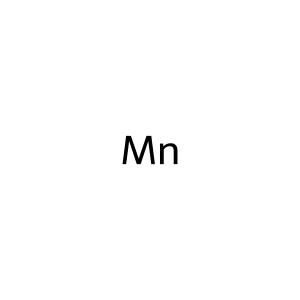

In [374]:
ligand_mol_1 = Chem.MolFromPDBFile('lig_3mvh_0.pdb')
Draw.MolToImage(ligand_mol_1)

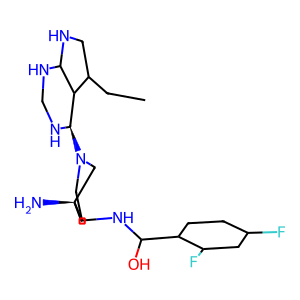

In [375]:
ligand_mol_2 = Chem.MolFromPDBFile('lig_3mvh_1.pdb')
Draw.MolToImage(ligand_mol_2)

In [ ]:
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
fragment_onbonds=Chem.FragmentOnBonds(ligand_mol_2, bond_list,addDummies=False)

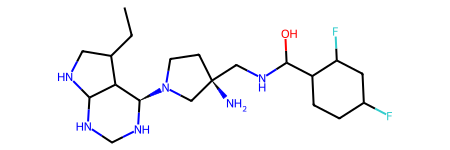

In [469]:
ligand_mol_2

In [ ]:
bond_list=[]
for bond in mol_2.GetBonds():
    if bond.IsInRing()==False:
        bond_list.append(bond.GetIdx())
        print(bond)
bond_list

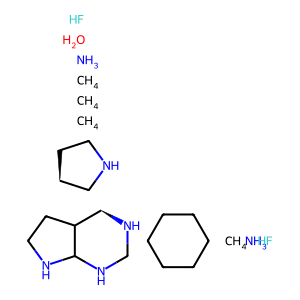

In [482]:
Draw.MolToImage(fragment_onbonds)